In [24]:
'''
We have computed phonetic labels for our LID dataset.
This code trains an attention-based classifier on the phonetic labels.

Example input:
b ɪ ɡ t oʊ f ɹ ɔ k f oʊ d ə k ɪ d z ʃ iː k æ n s k uː p ð iː z θ ɪ ŋ z ɪ n t ʊ t ɹ iː ɹ ɛ d b æ k s æ n d w iː w ɪ l

We will treat each phoneme as a token and train an attention-based classifier on the phonetic labels.

- Load the dataset
- Convert the phonetic labels to integers, using a single token per phonetic symbol.
- In the data collator, we will pad the sequences to the maximum length.
- We will use a transformer model with an attention mechanism to classify the phonetic labels.
'''

import torch
if torch.cuda.is_available():
    torch.ones(1).cuda()
import os, sys
import json
import numpy as np
import random
from collections import defaultdict
import torchaudio
from torch.utils.data import DataLoader
from tqdm import tqdm
import pickle as pkl
import re
# Log to wandb
import wandb
import logging

from argparse import ArgumentParser

sys.path.append("/home/hltcoe/nbafna/projects/mitigating-accent-bias-in-lid/utils/phoneseq_dataloading")
from phoneseq_dataset_loader import load_phoneseq_dataset

random.seed(42)

global logger

def get_logger(filename):
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    file_handler = logging.FileHandler(filename)
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    return logger


class AttentionsLinearModel(torch.nn.Module):

    def __init__(self, vocab_size, num_classes, hidden_size, num_attention_layers, attention_dim, padding_idx):
        super(AttentionsLinearModel, self).__init__()
        # Model architecture: input --> embedding --> linear --> transformer layers --> linear
        self.padding_idx = padding_idx
        self.embedding = torch.nn.Embedding(vocab_size, hidden_size, padding_idx=padding_idx)
    
        self.hidden_size = hidden_size
        self.num_attention_layers = num_attention_layers
        self.attention_dim = attention_dim

        self.linear_input = torch.nn.Linear(hidden_size, attention_dim)

        self.transformer_layer = torch.nn.TransformerEncoderLayer(d_model=attention_dim, 
                                                                   nhead=8, 
                                                                   dim_feedforward=256,
                                                                    dropout=0.1,
                                                                    activation='relu')
        self.transformer = torch.nn.TransformerEncoder(self.transformer_layer, num_layers=num_attention_layers)

        self.linear_output = torch.nn.Linear(attention_dim, num_classes)
    

    def forward(self, x):
        '''x : [batch_size, seq_len]'''
        ## We need to ignore padded tokens
        padding_mask = x == self.padding_idx
        # print(f"forward pass")
        # print(x)
        # Embedding layer
        x = self.embedding(x)
        # x: [batch_size, seq_len, hidden_size]
        x = self.linear_input(x)
        # x: [batch_size, seq_len, attention_dim]
        x = x.permute(1, 0, 2)
        # x: [seq_len, batch_size, attention_dim]
        x = self.transformer(x, src_key_padding_mask=padding_mask)
        # x: [seq_len, batch_size, attention_dim]
        x = x.permute(1, 0, 2)
        # x: [batch_size, seq_len, attention_dim]
        # Average the attention vectors, ignoring the padding tokens
        mask = ~padding_mask
        mask = mask.unsqueeze(-1)
        x = x * mask
        x = x.sum(dim=1) / (mask.sum(dim=1) + 1e-9)
        # x: [batch_size, attention_dim]
        x = self.linear_output(x)
        # x: [batch_size, num_classes]
        return x



class PostEncoder:

    def __init__(self, load_from_dir = False,  output_dir = None, batch_size = None, lr = None, num_epochs = None,\
        padding_idx = None):
        '''If load_from_dir is True, load the model from output_dir. Else, initialize a new model'''

        self.output_dir = output_dir
        self.batch_size = batch_size
        self.lr = lr
        self.num_epochs = num_epochs
        self.padding_idx = padding_idx
        

    def train(self, train_dataset, dev_dataset, collate_fn, evaluate_steps = None):

        if not torch.cuda.is_available():
            logger.error("CUDA is not available. Please run on a machine with CUDA")
            raise ValueError("CUDA is not available. Please run on a machine with CUDA")
        
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, collate_fn=collate_fn)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

        self.model = self.model.cuda()

        steps = 0
        for epoch in range(self.num_epochs):
            logger.info(f"Epoch: {epoch}")
            self.model.train()
            for batch in train_loader:
                # logger.info(f"Steps: {steps}")
                optimizer.zero_grad()
                input_values = batch["input_values"].cuda()
                labels = batch["labels"].cuda()
                assert self.model is not None and next(self.model.parameters()).is_cuda, "Model is not on GPU!"
                assert input_values.is_cuda, "Input is not on GPU!"
                assert labels.is_cuda, "Labels are not on GPU!"
                outputs = self.model(input_values)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                # logger.info(f"Epoch: {epoch}, Loss: {loss.item()}")
                wandb.log({"loss": loss.item()})
                steps += 1
                if evaluate_steps and steps % evaluate_steps == 0:

                    # Evaluate
                    _, _, _, accuracy = self.evaluate(dev_dataset)
                    wandb.log({"loss": loss.item()})
                    wandb.log({"accuracy": accuracy, "epoch": epoch})
                    logger.info(f"Epoch: {epoch}, Steps: {steps}, Accuracy: {accuracy}")


            if not evaluate_steps:
                # Log per epoch if evaluate_steps is not provided
                wandb.log({"loss": loss.item()})
                # Evaluate
                _, _, _, accuracy = self.evaluate(dev_dataset)
                wandb.log({"accuracy": accuracy, "epoch": epoch})
                logger.info(f"Epoch: {epoch}, Accuracy: {accuracy}")

            # Save the model after each epoch
            self.save()


    def predict(self, test_dataset, collate_fn):
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, collate_fn=collate_fn)
        self.model.eval()
        all_preds = []
        all_labels = []
        all_accents = []
        for batch in test_loader:
            input_values = batch["input_values"].cuda()
            with torch.no_grad():
                outputs = self.model(input_values)
                preds = torch.argmax(outputs, dim=1)
                all_preds.append(preds)
                all_labels.append(batch["labels"])
                all_accents.extend(batch["accents"])
        return torch.cat(all_preds), torch.cat(all_labels), all_accents
    
    def predict_output_distribution(self, test_dataset, collate_fn):
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, collate_fn=collate_fn)
        self.model.eval()
        all_preds = []
        all_labels = []
        all_accents = []
        for batch in test_loader:
            if torch.cuda.is_available():
                input_values = batch["input_values"].cuda()
            with torch.no_grad():
                outputs = self.model(input_values)
                preds = torch.argmax(outputs, dim=1)
                all_preds.append(preds)
                all_labels.append(batch["labels"])
                all_accents.extend(batch["accents"])
        return torch.cat(all_preds), torch.cat(all_labels), all_accents


    def evaluate(self, test_dataset, collate_fn):
        preds, labels, accents = self.predict(test_dataset)

        preds = preds.cpu()
        labels = labels.cpu()
        ###### DEBUG ######
        # logger.info(f"Number of samples: {len(labels)}")
        # logger.info(f"preds: {preds}")
        # logger.info(f"labels: {labels}")
        ###################
        correct = (preds == labels).sum().item()
        total = len(labels)
        logger.info(f"Accuracy: {correct/total}")
        return preds, labels, accents, correct/total
    
    def save(self, model_filename):
        torch.save(self.model, os.path.join(self.output_dir, model_filename))


class PhoneseqsLinearClassifiereonAttentionLayers(PostEncoder):

    def __init__(self, vocab_size, num_classes, hidden_size, num_attention_layers, attention_dim, load_from_dir = False,  output_dir = None, batch_size = None, lr = None, num_epochs = None, \
        padding_idx = 0):
        '''If load_from_dir is True, load the model from output_dir. Else, initialize a new model'''
        if load_from_dir:
            model = torch.load(os.path.join(output_dir, f"phoneseqs_attentions-{num_attention_layers}_classifier.pth"), map_location=torch.device('cpu') )
        else:
            model = AttentionsLinearModel(vocab_size=vocab_size, num_classes=num_classes, \
                                          hidden_size=hidden_size, \
                                            num_attention_layers=num_attention_layers, \
                                            attention_dim=attention_dim, \
                                                padding_idx=padding_idx)
        
        if torch.cuda.is_available():
            self.model = model.cuda()
        else:
            self.model = model

        super().__init__(load_from_dir, output_dir, batch_size, lr, num_epochs, padding_idx)
        


    def train(self, train_dataset, dev_dataset, evaluate_steps = None):

        wandb.init(project=f"train_lid_on_phoneseqs_attentions", config={
            "batch_size": self.batch_size,
            "num_epochs": self.num_epochs,
            "learning_rate": self.lr,
            "num_attention_layers": self.model.num_attention_layers,
            "attention_dim": self.model.attention_dim,
            "hidden_size": self.model.hidden_size,
            "output_dir": self.output_dir,
        })
        super().train(train_dataset, dev_dataset, collate_fn, evaluate_steps)


    def predict(self, test_dataset):
        return super().predict(test_dataset, collate_fn)


    def evaluate(self, test_dataset):
        return super().evaluate(test_dataset, collate_fn)
    
    def save(self):
        super().save(f"phoneseqs_attentions-{self.model.num_attention_layers}_classifier.pth")



def parse_args():
    parser = ArgumentParser()
    parser.add_argument("--dataset_dir", type=str, required=True, help="Directory containing transcribed audio files")
    
    parser.add_argument("--per_lang", type=int, default=None, help="Number of audio files per language")
    parser.add_argument("--num_epochs", type=int, default=10, help="Number of epochs")
    parser.add_argument("--batch_size", type=int, default=1, help="Batch size")
    parser.add_argument("--evaluate_steps", type=int, default=None, help="Evaluate every n steps")
    parser.add_argument("--lr", type=float, default=1e-3, help="Learning rate")
    parser.add_argument("--output_dir", type=str, default="/exp/nbafna/projects/mitigating-accent-bias-in-lid/wav2vec2_intermediate_outputs", help="Output directory for LID model")
    parser.add_argument("--load_trained_from_dir", action="store_true", help="Load the model from output_dir")
    parser.add_argument("--lid_model_type", type=str, default="linear", help="Type of model to train")
    parser.add_argument("--logfile", type=str, default="train.log", help="Log file")
    parser.add_argument("--num_attention_layers", type=int, default=None, help="Number of attention layers")

    parser.add_argument("--only_eval", action="store_true", help="Only evaluate the model")
    parser.add_argument("--eval_dataset_dir", type=str, default=None, help="Directory containing evaluation dataset")
    return parser.parse_args()


def get_lang2idx_map(dataset_dir):
    '''Get the mapping from language to index'''

    global logger

    ### CHANGE THIS TO DATASET_DIR
    # langs = os.listdir(training_units_dir)

    if dataset_dir == "vl107":
        langs_dir = "/exp/jvillalba/corpora/voxlingua107"
    elif dataset_dir == "fleurs":
        langs_dir = "/export/common/data/corpora/fleurs/metadata"
    langs = sorted(os.listdir(langs_dir))

    #### For now, we'll just use langs that have non-empty directories in the output_dir ####
    # langs = [lang for lang in langs if len(os.listdir(os.path.join(training_units_dir, lang))) > 0]

    lang2idx = {lang: idx for idx, lang in enumerate(langs)}
    idx2lang = {idx: lang for lang, idx in lang2idx.items()}
    # langs = ["ar", "hi", "en"]
    # logger.info(f"Number of languages: {len(langs)}")
    return lang2idx, idx2lang, langs


def map_tokenize_phoneme_labels(batch, phoneme2idx, lang2idx):
    '''Tokenize the phoneme labels and convert labels to integers
    batch: {"phone_sequence": [str], "lang": [str], "accent": [str], "audio_file": [str]}
    '''
    phoneme_sequences = batch["phone_sequence"]
    coded_phoneme_sequences = []
    for phoneme_sequence in phoneme_sequences:
        coded_phoneme_sequence = [phoneme2idx[phoneme] for phoneme in phoneme_sequence \
            if phoneme in phoneme2idx]
        coded_phoneme_sequences.append(coded_phoneme_sequence)
    batch["sequence"] = coded_phoneme_sequences

    # HACK to handle the case where eval dataset codes don't have training dataset codes
    ## Since we're only evaluating on English, this only applies to English
    ## For training languages, this will not be an issue
    eng_eqv = [lang for lang in lang2idx if "en" in lang][0] # There should be only one
    for i, lang in enumerate(batch["lang"]):
        if lang not in lang2idx and "en" in lang:
            # Replace with the equivalent
            batch["lang"][i] = eng_eqv
    batch["label"] = [lang2idx[lang] for lang in batch["lang"]]

    return batch


def collate_fn(batch):
    '''Pad the phoneme sequences to the maximum length'''
    model_max_len = 256
    padding_idx = 0
    sequences = [torch.tensor(item["sequence"]) for item in batch]
    truncated_sequences = [seq[:model_max_len] for seq in sequences]
    labels = [item["label"] for item in batch]
    accents = [item["accent"] for item in batch]

    # Pad the sequences with padding_idx=0
    padded_sequences = torch.nn.utils.rnn.pad_sequence(truncated_sequences, batch_first=True, padding_value=padding_idx)
    labels = torch.tensor(labels)
    return {"input_values": padded_sequences, "labels": labels, "accents": accents}



def get_dataset_splits(lid_dataset, dev_size = 0.05, test_size = 0.1):
    '''Split the dataset into train and dev'''
    global logger
    if dev_size < 1:
        # Fraction
        num_dev = int(dev_size * len(lid_dataset))
        num_test = int(test_size * len(lid_dataset))
    else:
        # Number
        num_dev = dev_size
        num_test = test_size
    indices = list(range(len(lid_dataset)))
    random.shuffle(indices)
    dev_indices = indices[:num_dev]
    test_indices = indices[num_dev:num_dev+num_test]
    train_indices = indices[num_dev+num_test:]
    train_dataset = lid_dataset.select(train_indices)
    dev_dataset = lid_dataset.select(dev_indices)
    test_dataset = lid_dataset.select(test_indices)

    logger.info(f"Number of samples in train: {len(train_dataset)}")
    logger.info(f"Number of samples in dev: {len(dev_dataset)}")
    logger.info(f"Number of samples in test: {len(test_dataset)}")

    return train_dataset, dev_dataset, test_dataset



def main():

    global logger

    args = parse_args()
    dataset_dir = args.dataset_dir
    per_lang = args.per_lang
    lid_model_type = args.lid_model_type
    output_dir = args.output_dir
    num_epochs = args.num_epochs
    batch_size = args.batch_size
    lr = args.lr
    evaluate_steps = args.evaluate_steps
    load_trained_from_dir = args.load_trained_from_dir
    num_attention_layers = args.num_attention_layers
    only_eval = args.only_eval
    eval_dataset_dir = args.eval_dataset_dir

    logger = get_logger(args.logfile)

    lang2idx, idx2lang, langs = get_lang2idx_map(dataset_dir)

    # Tokenize the phonetic sequences and labels
    phoneme2idx_file = "/home/hltcoe/nbafna/projects/mitigating-accent-bias-in-lid/utils/wav2vec2phoneme_map/wav2vec2phoneme_map.json"
    with open(phoneme2idx_file, "r") as f:
        phoneme2idx = json.load(f)
    idx2phoneme = {idx: phoneme for phoneme, idx in phoneme2idx.items()}

    if not only_eval:
        # Load dataset
        lid_dataset = load_phoneseq_dataset(dataset_dir, per_lang=per_lang)

        # Get the mapping from language to index
        
        lid_dataset = lid_dataset.map(map_tokenize_phoneme_labels, fn_kwargs={"phoneme2idx": phoneme2idx, "lang2idx": lang2idx}, \
            batched=True, \
            batch_size = 1000)
        
        # Split the dataset into training and validation
        train_dataset, dev_dataset, test_dataset = get_dataset_splits(lid_dataset, dev_size = 1000, test_size = 10000)
    

    assert lid_model_type in ["attentions-linear"], "Invalid LID model type"
    if only_eval:
        assert load_trained_from_dir, "If only evaluating, you must load the model from a directory"

    logger.info(f"Type of LID model: {lid_model_type}")
    
    if lid_model_type == "attentions-linear":

        vocab_size = len(phoneme2idx)
        hidden_size = 256
        num_classes = len(idx2lang)
        logger.info(f"Num classes: {num_classes}")
        lid_model = PhoneseqsLinearClassifiereonAttentionLayers(vocab_size=vocab_size, num_classes=num_classes, \
                                hidden_size=hidden_size, num_attention_layers=num_attention_layers, \
                                    attention_dim=128, \
                                    load_from_dir = load_trained_from_dir, output_dir = output_dir, \
                                    batch_size = batch_size, lr = lr, num_epochs = num_epochs)

    
    
    # Train the model
    if not only_eval:
        logger.info(f"Training model...")
        lid_model.train(train_dataset, dev_dataset, evaluate_steps = evaluate_steps)
        lid_model.save()

        # Evaluate the model
        logger.info(f"Evaluating model on test split of train dataset...")
        preds, labels, accents, accuracy = lid_model.evaluate(test_dataset)
        logger.info(f"Accuracy: {accuracy}")

        # Save the predictions
        ## We'll save a list of audio files, their predicted labels, and their true labels
        # audio_files_test = [item["audio_file"] for item in test_dataset]
        preds = preds.cpu().numpy()
        labels = labels.cpu().numpy()
        # accents = accents.cpu().numpy()
        preds = [idx2lang[pred] for pred in preds]
        labels = [idx2lang[label] for label in labels]

        with open(os.path.join(output_dir, "testset_predictions.pkl"), "wb") as f:
            # pkl.dump({"audio_files": audio_files_test, "preds": preds, "labels": labels}, f)
            pkl.dump({"preds": preds, "labels": labels, "accents": accents}, f)

        with open(os.path.join(output_dir, f"eval_accuracy.json"), "w") as f:
            json.dump({f"{dataset_dir}_test_accuracy": accuracy}, f)

    # Evaluate the model on eval dataset if provided

    if eval_dataset_dir:
        logger.info(f"Evaluating model on eval dataset...")
        eval_dataset = load_phoneseq_dataset(eval_dataset_dir, target_code_type = dataset_dir)

        eval_dataset = eval_dataset.map(map_tokenize_phoneme_labels, fn_kwargs={"phoneme2idx": phoneme2idx, "lang2idx": lang2idx}, \
            batched=True, \
            batch_size = 1000)

        logger.info(f"Evaluating model on eval dataset...")
        preds, labels, accents, accuracy = lid_model.evaluate(eval_dataset)
        logger.info(f"Accuracy: {accuracy}")


        # Save the predictions
        ## We'll save a list of audio files, their predicted labels, and their true labels
        # audio_files_test = [item["audio_file"] for item in test_dataset]
        preds = preds.cpu().numpy()
        labels = labels.cpu().numpy()
        # accents = accents.cpu().numpy()
        preds = [idx2lang[pred] for pred in preds]
        labels = [idx2lang[label] for label in labels]

        with open(os.path.join(output_dir, f"{eval_dataset_dir}_predictions.pkl"), "wb") as f:
            # pkl.dump({"audio_files": audio_files_test, "preds": preds, "labels": labels}, f)
            pkl.dump({"preds": preds, "labels": labels, "accents": accents}, f)
        
        # Save accuracy to JSON file

        if os.path.exists(os.path.join(output_dir, f"eval_accuracy.json")):
            results = json.load(open(os.path.join(output_dir, f"eval_accuracy.json")))
        else:
            results = {}
        
        results[f"{eval_dataset_dir}_accuracy"] = accuracy

        with open(os.path.join(output_dir, f"eval_accuracy.json"), "w") as f:
            json.dump(results, f, indent=4)


# if __name__ == "__main__":

#     main()


In [39]:
'''Loads a dataset that looks like this:
{'signal': np.array, 'lang': str, 'accent': str, 'audio_file': str}
And adds reps from a given encoder model, as well as phoneme sequences from a given transcriber model.

{'lang': str, 'accent': str, \
    'audio_file': str, \
    'reps': torch.tensor, \
    'phone_sequence': list}

Writes the dataset to disk.

Can also be used to load a dataset that has previously  been computed.
''' 


import torch
device=None
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    torch.ones(1).to(device)


from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from datasets import load_dataset
import torch
import numpy as np
from argparse import ArgumentParser
from torch.utils.data import DataLoader
import os, sys
sys.path.append("/home/hltcoe/nbafna/projects/mitigating-accent-bias-in-lid/utils/dataloading/")
from dataset_loader import load_lid_dataset
# from vl107 import load_vl107, load_vl107_lang
# from edacc import load_edacc

from tqdm import tqdm

import logging

def get_logger(filename):
    if not filename:
        return None
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    file_handler = logging.FileHandler(filename)
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    return logger

global logger


def parse_args():
    parser = ArgumentParser()
    parser.add_argument("--transcriber_model", type=str, required=True, help="Model used to transcribe the audio files")
    parser.add_argument("--encoder_model", type=str, required=True, help="Model used to encode the audio files for acoustic representations")

    parser.add_argument("--dataset_name", type=str, required=True, help="Dataset name for loading (see dataset_loader.py)")

    parser.add_argument("--per_lang", type=int, default=None, help="Number of audio files per language")
    parser.add_argument("--lang", type=str, default=None, help="Language to extract audio files from")
    parser.add_argument("--batch_size", type=int, default=1, help="Batch size")
    parser.add_argument("--output_dir", type=str, required=True, help="Output directory")
    parser.add_argument("--write_every_n_batches", type=int, default=100, help="Write to disk every n batches")
    parser.add_argument("--log_file", type=str, default="train.log", help="Log file")
    
    return parser.parse_args()


def prepare_dataset(batch, processor = None):
    
    array_values = [np.array(signal).squeeze() for signal in batch["signal"]]
    batch["input_values"] = processor(array_values, sampling_rate = 16_000, \
                                    padding = True, \
                                    return_tensors="pt").input_values

    return batch


# def collate_fn(batch):
#     return {
#         "input_values": torch.stack([torch.tensor(item["input_values"]) for item in batch]),
#         # "wav_files": [item["wav_file"] for item in batch],
#         # "text_files": [item["text_file"] for item in batch],
#         # "timestamp_files": [item["timestamp_file"] for item in batch],
#         "lengths": [item["lengths"] for item in batch],
#         "lang": [item["lang"] for item in batch],
#         "audio_file": [item["audio_file"] for item in batch],
#         "accent": [item["accent"] for item in batch],
#     }



def map_encode_audio(batch, model_name, model, processor = None):
    '''
    Adds the acoustic representations to the batch
    '''
    if model_name == "ecapa-tdnn":
        signals = torch.stack([torch.tensor(signal) for signal in batch["signal"]])
        signals = signals.to(device)
        outputs = model.classify_batch(signals)
        print(outputs[0])
        output_distributions = [output.exp() for output in outputs[0]]
        batch["et_output_distributions"] = output_distributions
    
    else:
        raise NotImplementedError("Model not supported")

    return batch


def map_transcribe(batch, transcriber_model, processor = None):
    '''
    Adds the phoneme sequences to the batch
    '''
    input_values = torch.stack([torch.tensor(input_value) for input_value in batch["input_values"]])
    input_values = input_values.to(device)

    with torch.no_grad():
        logits = transcriber_model(input_values).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)
    batch["phone_sequence"] = transcription

    return batch
    

def dataset_main(transcriber_model, encoder_model, dataset_dir, per_lang, lang, batch_size, output_dir, log_file=None, rewrite=False):

    global logger
    logger = get_logger(log_file)

    outfile = os.path.join(output_dir, f"{lang}_transcriptions.jsonl")
    # Load the dataset if it exists
    if os.path.exists(outfile) and not rewrite:
        # logger.info(f"Dataset {outfile} already exists")
        dataset = load_dataset("json", data_files = outfile)

        return dataset

        # Load the dataset
    if logger:
        logger.info(f"Loading dataset: {dataset_dir}")

    dataset = load_lid_dataset(dataset_dir, lang = lang, per_lang = per_lang)
    if dataset is None:
        if logger:
            logger.info(f"Dataset {dataset_dir} for lang {lang} not found")
        return None

    # Load the model
    if encoder_model == "ecapa-tdnn":
        # Load the model
        if logger:
            logger.info(f"Loading model: {encoder_model}")
        from speechbrain.inference.classifiers import EncoderClassifier

        encoder = EncoderClassifier.from_hparams(source="speechbrain/lang-id-voxlingua107-ecapa", savedir="tmp") #, run_opts={"device":"cuda"})
        print(f"Calculating acoustic representations for {len(dataset)} samples")
        dataset = dataset.map(map_encode_audio, fn_kwargs = {"model_name": encoder_model, "model": encoder}, \
                            batched=True, batch_size=64)



    ######## TRANSCRIBING ##########
    if logger:
        logger.info(f"Loading transcriber model: {transcriber_model}")
    if transcriber_model != "facebook/wav2vec2-xlsr-53-espeak-cv-ft":
        raise NotImplementedError("Model not supported")

    # processor = AutoProcessor.from_pretrained(model_name)
    transcriber_processor = Wav2Vec2Processor.from_pretrained(transcriber_model)
    # "facebook/wav2vec2-xlsr-53-espeak-cv-ft"
    print(f"Preparing dataset with processor for {transcriber_model}")
    dataset = dataset.map(prepare_dataset, fn_kwargs = {"processor": transcriber_processor} , \
                          batched=True, batch_size=batch_size, \
                          remove_columns=["signal"])
                        #   num_proc=4, writer_batch_size=100, keep_in_memory=False, remove_columns=["signal"])

    
    model = Wav2Vec2ForCTC.from_pretrained(transcriber_model)
    model.eval()
    model.to(device)
    print(f"Transcribing {len(dataset)} samples")
    dataset = dataset.map(map_transcribe, fn_kwargs = {"transcriber_model": model, "processor": transcriber_processor}, \
                            batched=True, batch_size=batch_size, \
                            remove_columns=["input_values"])
    
    # Write HF dataset to disk
    # dataset.to_json(outfile)
    # if logger:
    #     logger.info(f"Dataset written to {outfile}")
    # print(f"Dataset written to {outfile}")

    return dataset


    
# if __name__ == "__main__":
#     args = parse_args()
    
#     transcriber_model = args.transcriber_model
#     encoder_model = args.encoder_model

#     dataset_dir = args.dataset_name
#     per_lang = args.per_lang # This is number of samples per language for VL107 and FLEURS, 
#                              # number of total samples over all accents for EDACC
#                              # and number of samples per accent for CV 
#     lang = args.lang
#     batch_size = args.batch_size
#     output_dir = args.output_dir

#     log_file = args.log_file
    
#     main(transcriber_model, encoder_model, dataset_dir, per_lang, lang, batch_size, output_dir, log_file)

In [84]:
transcriber_model = "facebook/wav2vec2-xlsr-53-espeak-cv-ft"
encoder_model = "ecapa-tdnn"

# dataset_dir = "fleurs_test"
dataset_dir = "edacc"
per_lang = 200
lang = "en"
batch_size = 4
output_dir = "test"

am_dataset = dataset_main(transcriber_model, encoder_model, dataset_dir, per_lang, lang, batch_size, output_dir, log_file=None, rewrite=False)
# cv_dataset = dataset_main(transcriber_model, encoder_model, dataset_dir, per_lang, lang, batch_size, output_dir, log_file=None, rewrite=False)

Loaded 76 audio files
Recorded 122 speakers
Loaded 13213 segments
Sample: {'signal': array([-2.5101658e-04, -3.3711875e-04, -4.3454114e-04, ...,
       -8.6554268e-05, -2.1143309e-04, -1.7558667e-04], dtype=float32), 'lang': 'en', 'accent': 'scottish', 'audio_file': 'EDACC-C08'}
Accents: {'israeli', 'ecuadorian', 'dutch', 'chinese', 'pakistani', 'icelandic', 'egyptian', 'chilean', 'kenyan', 'mexican', 'spanish', 'russian', 'tagalog', 'italian', 'ghanian', 'romanian', 'colombian', 'filipino', 'korean', 'catalan', 'japanese', 'montenegrin', 'nigerian', 'bulgarian', 'brazilian', 'jamaican', 'indonesian', 'south african', 'french', 'uk', 'shona', 'indian', 'vietnamese', 'polish', 'us', 'scottish', 'lithuanian', 'american', 'irish', 'macedonian', 'sinhalese'}


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/lang-id-voxlingua107-ecapa' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/lang-id-voxlingua107-ecapa' if not cached
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/lang-id-voxlingua107-ecapa' if not cached
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/lang-id-voxlingua107-ecapa' if not cached
INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'speechbrain/lang-id-voxlingua107-ecapa' if not cached
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: embedding_model, classifier, label_encoder
/home/hltcoe/nbafna/.conda/envs/accent_bias/lib/python3.12/site-packages/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the

Calculating acoustic representations for 200 samples


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

tensor([[-14.5057, -11.9783, -11.4083,  ...,  -7.3470,  -1.5701, -12.7521],
        [-15.0981, -11.9594,  -9.3763,  ..., -15.0850,  -2.1714, -11.4083],
        [-13.6745, -11.3050, -15.3061,  ...,  -7.8582,  -8.5561, -10.7502],
        ...,
        [-18.2693, -14.6532,  -9.0680,  ...,  -5.4388,  -8.7655, -10.6872],
        [ -7.6632, -12.2610, -10.2247,  ...,  -9.9987,  -8.2124, -11.8627],
        [-19.4177,  -4.4325,  -9.8437,  ...,  -8.7675, -10.1898, -15.2603]])
tensor([[-12.8231,  -0.9965,  -9.4599,  ..., -11.8542, -10.4503, -10.2701],
        [-15.0943,  -6.4714, -14.4029,  ...,  -8.9706, -15.6617, -15.7407],
        [-14.3731, -14.3065, -12.5401,  ..., -13.0816, -18.5253, -12.8601],
        ...,
        [-15.3514,  -7.1979,  -5.1418,  ...,  -8.0013, -14.8495, -11.6792],
        [-20.8890, -12.5988, -15.1844,  ...,  -9.1439, -16.6738, -14.0846],
        [-17.5891,  -6.8613,  -7.2966,  ...,  -7.6474,  -5.7176,  -6.2832]])
tensor([[-15.0976,  -7.8995, -10.3859,  ..., -10.2528, -18.6

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Some weights of the model checkpoint at facebook/wav2vec2-xlsr-53-espeak-cv-ft were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-xlsr-53-espeak-cv-ft and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should prob

Transcribing 200 samples


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [85]:
len(am_dataset)
# save hf dataset to disk
am_dataset.to_json("/home/hltcoe/nbafna/projects/mitigating-accent-bias-in-lid/lid_with_acoustics-phoneseq/test_datasets/fleurs_test_am.jsonl")

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

337204

In [86]:
def split_ps(batch):
    batch["phone_sequence"] = [p.split() for p in batch["phone_sequence"]]
    return batch

# cv_dataset = cv_dataset.map(split_ps, batched=True)
dataset = am_dataset.map(split_ps, batched=True)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [87]:
dataset[0]

{'accent': 'ghanian',
 'lang': 'en',
 'audio_file': 'EDACC-C36_P1',
 'et_output_distributions': [5.014790644963796e-07,
  6.278782620938728e-06,
  1.1102868484158535e-05,
  4.375874596007634e-06,
  9.381814379594289e-06,
  6.309894473588429e-08,
  2.9877134100075864e-09,
  6.882887646497693e-07,
  3.8500445498357294e-07,
  4.02827026846353e-06,
  0.00012503861216828227,
  1.1155740367030376e-06,
  6.760229734936729e-05,
  1.0357349538026028e-06,
  9.540964674670249e-05,
  2.740563900260895e-07,
  0.004150030203163624,
  4.5821419917047024e-05,
  2.9595128125947667e-06,
  6.41475210727549e-08,
  0.04531828686594963,
  2.6056904971483164e-06,
  4.176197762717493e-06,
  4.815353804588085e-08,
  9.684315955382772e-06,
  8.061990229180083e-05,
  2.1891553387831664e-06,
  4.050356801599264e-05,
  1.483345840824768e-06,
  6.00484142410096e-08,
  6.182833658385789e-07,
  1.3106671303830808e-06,
  0.00027940800646319985,
  0.00018286735576111823,
  0.000952626287471503,
  3.0463623261312023e-05

In [88]:
import torch
softmax = torch.nn.Softmax(dim=0)

dataset_dir = "vl107"
per_lang = 5
lang = "en"
batch_size = 1
only_eval = True
load_trained_from_dir = True
lid_model_type = "attentions-linear"
num_attention_layers = 4
num_epochs = 10
lr = 1e-3
evaluate_steps = 100
output_dir = "/exp/nbafna/projects/mitigating-accent-bias-in-lid/phoneseq_exps/vl107/wav2vec2-xlsr-53-espeak-cv-ft/attentions-linear-4/phoneseq_lid_model_outputs/"
eval_dataset_dir = "fleurs_test"

lang2idx, idx2lang, langs = get_lang2idx_map(dataset_dir)  




def collate_fn_with_et_dists(batch):
    '''Pad the phoneme sequences to the maximum length'''
    model_max_len = 256
    padding_idx = 0
    sequences = [torch.tensor(item["sequence"]) for item in batch]
    truncated_sequences = [seq[:model_max_len] for seq in sequences]
    labels = [item["label"] for item in batch]
    accents = [item["accent"] for item in batch]
    et_output_distributions = [item["et_output_distributions"] for item in batch]

    # Pad the sequences with padding_idx=0, padded_sequences should be int tensor
    padded_sequences = torch.nn.utils.rnn.pad_sequence(truncated_sequences, batch_first=True, padding_value=padding_idx)
    padded_sequences = padded_sequences.type(torch.int64)
    labels = torch.tensor(labels)
    return {"input_values": padded_sequences, "labels": labels, "accents": accents, "et_output_distributions": et_output_distributions}



# Tokenize the phonetic sequences and labels
phoneme2idx_file = "/home/hltcoe/nbafna/projects/mitigating-accent-bias-in-lid/utils/wav2vec2phoneme_map/wav2vec2phoneme_map.json"
with open(phoneme2idx_file, "r") as f:
    phoneme2idx = json.load(f)
idx2phoneme = {idx: phoneme for phoneme, idx in phoneme2idx.items()}

if not only_eval:
    # Load dataset
    lid_dataset = load_phoneseq_dataset(dataset_dir, per_lang=per_lang)

    # Get the mapping from language to index
    
    lid_dataset = lid_dataset.map(map_tokenize_phoneme_labels, fn_kwargs={"phoneme2idx": phoneme2idx, "lang2idx": lang2idx}, \
        batched=True, \
        batch_size = 1000)
    
    # Split the dataset into training and validation
    train_dataset, dev_dataset, test_dataset = get_dataset_splits(lid_dataset, dev_size = 1000, test_size = 10000)


assert lid_model_type in ["attentions-linear"], "Invalid LID model type"
if only_eval:
    assert load_trained_from_dir, "If only evaluating, you must load the model from a directory"

# logger.info(f"Type of LID model: {lid_model_type}")

if lid_model_type == "attentions-linear":

    vocab_size = len(phoneme2idx)
    hidden_size = 256
    num_classes = len(idx2lang)
    # logger.info(f"Num classes: {num_classes}")
    lid_model = PhoneseqsLinearClassifiereonAttentionLayers(vocab_size=vocab_size, num_classes=num_classes, \
                            hidden_size=hidden_size, num_attention_layers=num_attention_layers, \
                                attention_dim=128, \
                                load_from_dir = load_trained_from_dir, output_dir = output_dir, \
                                batch_size = batch_size, lr = lr, num_epochs = num_epochs)



# Train the model
if not only_eval:
    logger.info(f"Training model...")
    lid_model.train(train_dataset, dev_dataset, evaluate_steps = evaluate_steps)
    lid_model.save()

    # Evaluate the model
    logger.info(f"Evaluating model on test split of train dataset...")
    preds, labels, accents, accuracy = lid_model.evaluate(test_dataset)
    logger.info(f"Accuracy: {accuracy}")

    # Save the predictions
    ## We'll save a list of audio files, their predicted labels, and their true labels
    # audio_files_test = [item["audio_file"] for item in test_dataset]
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    # accents = accents.cpu().numpy()
    preds = [idx2lang[pred] for pred in preds]
    labels = [idx2lang[label] for label in labels]

    with open(os.path.join(output_dir, "testset_predictions.pkl"), "wb") as f:
        # pkl.dump({"audio_files": audio_files_test, "preds": preds, "labels": labels}, f)
        pkl.dump({"preds": preds, "labels": labels, "accents": accents}, f)

    with open(os.path.join(output_dir, f"eval_accuracy.json"), "w") as f:
        json.dump({f"{dataset_dir}_test_accuracy": accuracy}, f)

# Evaluate the model on eval dataset if provided

if eval_dataset_dir:
    # logger.info(f"Evaluating model on eval dataset...")
    # eval_dataset = load_phoneseq_dataset(eval_dataset_dir, target_code_type = dataset_dir)
    # eval_dataset = cv_dataset
    eval_dataset = dataset
    # eval_dataset = dataset.filter(lambda x: len(x["phone_sequence"]) > 0)

    eval_dataset = eval_dataset.map(map_tokenize_phoneme_labels, fn_kwargs={"phoneme2idx": phoneme2idx, "lang2idx": lang2idx}, \
        batched=True, \
        batch_size = 1000)

    # logger.info(f"Evaluating model on eval dataset...")
    # preds, labels, accents, accuracy = lid_model.evaluate(eval_dataset)
    # logger.info(f"Accuracy: {accuracy}")
    def predict_output_distribution(self, test_dataset, collate_fn):
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, collate_fn=collate_fn)
        self.model.eval()
        all_phoneseq_output_dists = []
        all_et_output_dists = []
        all_labels = []
        all_accents = []
        for batch in test_loader:
            if torch.cuda.is_available():
                input_values = batch["input_values"].cuda()
            else:
                input_values = batch["input_values"]
            with torch.no_grad():
                print(input_values)
                outputs = lid_model.model(input_values)
                outputs = [softmax(output) for output in outputs]
                all_phoneseq_output_dists.extend(outputs)
                et_output_dists = torch.tensor(batch["et_output_distributions"])
                all_et_output_dists.extend(et_output_dists)
                # preds = torch.argmax(outputs, dim=1)
                
                # all_preds.append(preds)
                all_labels.extend([label.item() for label in batch["labels"]])
                all_accents.extend(batch["accents"])
        return all_phoneseq_output_dists, all_et_output_dists, all_labels, all_accents
    
    phoneseq_output_dists, et_output_dists, all_labels, all_accents = predict_output_distribution(lid_model, eval_dataset, collate_fn_with_et_dists)




    # Save the predictions
    ## We'll save a list of audio files, their predicted labels, and their true labels
    # audio_files_test = [item["audio_file"] for item in test_dataset]
    # preds = preds.cpu().numpy()
    # labels = labels.cpu().numpy()
    # accents = accents.cpu().numpy()
    # preds = [idx2lang[pred] for pred in preds]
    # labels = [idx2lang[label] for label in labels]

    # with open(os.path.join(output_dir, f"{eval_dataset_dir}_predictions.pkl"), "wb") as f:
    #     # pkl.dump({"audio_files": audio_files_test, "preds": preds, "labels": labels}, f)
    #     pkl.dump({"preds": preds, "labels": labels, "accents": accents}, f)
    
    # # Save accuracy to JSON file

    # if os.path.exists(os.path.join(output_dir, f"eval_accuracy.json")):
    #     results = json.load(open(os.path.join(output_dir, f"eval_accuracy.json")))
    # else:
    #     results = {}
    
    # results[f"{eval_dataset_dir}_accuracy"] = accuracy


/tmp/ipykernel_6641/1945168026.py:230: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(os.path.join(output_dir, f"phoneseqs_attentions-{num_attention_layers

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

tensor([[17,  5, 17, 21, 27, 17,  8, 10, 13, 37, 12, 27, 30, 13,  8, 36,  4, 12,
         37, 32, 29, 12, 32, 40,  4,  6, 29, 26,  9,  4, 40,  6,  7, 35, 55, 17,
          4,  5, 44,  5,  5, 30]])
forward pass
tensor([[17,  5, 17, 21, 27, 17,  8, 10, 13, 37, 12, 27, 30, 13,  8, 36,  4, 12,
         37, 32, 29, 12, 32, 40,  4,  6, 29, 26,  9,  4, 40,  6,  7, 35, 55, 17,
          4,  5, 44,  5,  5, 30]])
tensor([[19, 11, 51, 10, 54, 23,  9, 18, 19, 12,  9, 53, 11, 10, 18, 19,  4,  6,
         16,  8, 24, 46,  8, 16, 60, 10,  5,  9, 26, 16,  6,  9, 11, 34]])
forward pass
tensor([[19, 11, 51, 10, 54, 23,  9, 18, 19, 12,  9, 53, 11, 10, 18, 19,  4,  6,
         16,  8, 24, 46,  8, 16, 60, 10,  5,  9, 26, 16,  6,  9, 11, 34]])
tensor([[20, 39, 40,  4, 60,  7, 12,  9,  8, 20, 30, 32, 14,  4, 13, 33, 22, 43,
         17, 21, 60, 55,  5, 24, 30, 27, 17, 13, 14, 13, 26, 43, 32, 14]])
forward pass
tensor([[20, 39, 40,  4, 60,  7, 12,  9,  8, 20, 30, 32, 14,  4, 13, 33, 22, 43,
         17, 21, 6

In [89]:
et_accuracy = 0
phoneseq_accuracy = 0
combined_accuracy = 0
for i in range(len(phoneseq_output_dists)):
    et_pred = idx2lang[torch.argmax(et_output_dists[i], dim=0).item()]
    phoneseq_pred = idx2lang[torch.argmax(phoneseq_output_dists[i], dim=0).item()]

    # Combined prediction, by taking the average of the two output distributions
    combined_output_dist = (et_output_dists[i] + phoneseq_output_dists[i])/2
    combined_pred = idx2lang[torch.argmax(combined_output_dist, dim=0).item()]

    true_label = all_labels[i]
    accent = all_accents[i]
    
    if et_pred == idx2lang[true_label]:
        et_accuracy += 1
    if phoneseq_pred == idx2lang[true_label]:
        phoneseq_accuracy += 1
    if combined_pred == idx2lang[true_label]:
        combined_accuracy += 1

    if et_pred != phoneseq_pred:
        print(f"Sample {i}")
        print(f"ET Prediction: {et_pred}")
        print(f"Phoneseq Prediction: {phoneseq_pred}")
        print(f"Combined Prediction: {combined_pred}")
        print(f"True Label: {idx2lang[true_label]}")
        print(f"Accent: {accent}")
        print("\n")

et_accuracy = et_accuracy/len(phoneseq_output_dists)
phoneseq_accuracy = phoneseq_accuracy/len(phoneseq_output_dists)
combined_accuracy = combined_accuracy/len(phoneseq_output_dists)

print(f"ET Accuracy: {et_accuracy}")
print(f"Phoneseq Accuracy: {phoneseq_accuracy}")
print(f"Combined Accuracy: {combined_accuracy}")

Sample 0
ET Prediction: sn
Phoneseq Prediction: yo
Combined Prediction: yo
True Label: en
Accent: ghanian


Sample 1
ET Prediction: pt
Phoneseq Prediction: yo
Combined Prediction: yo
True Label: en
Accent: nigerian


Sample 3
ET Prediction: yo
Phoneseq Prediction: af
Combined Prediction: yo
True Label: en
Accent: nigerian


Sample 4
ET Prediction: en
Phoneseq Prediction: da
Combined Prediction: en
True Label: en
Accent: jamaican


Sample 6
ET Prediction: tl
Phoneseq Prediction: en
Combined Prediction: en
True Label: en
Accent: colombian


Sample 7
ET Prediction: cy
Phoneseq Prediction: fo
Combined Prediction: cy
True Label: en
Accent: scottish


Sample 8
ET Prediction: lb
Phoneseq Prediction: yi
Combined Prediction: yi
True Label: en
Accent: ghanian


Sample 9
ET Prediction: cy
Phoneseq Prediction: en
Combined Prediction: en
True Label: en
Accent: spanish


Sample 10
ET Prediction: cy
Phoneseq Prediction: yi
Combined Prediction: cy
True Label: en
Accent: irish


Sample 12
ET Prediction

In [56]:
dataset[0]

{'lang': 'ceb',
 'accent': '-',
 'audio_file': '/export/common/data/corpora/fleurs/ceb_ph/test/14217343276582898501.wav',
 'et_output_distributions': [5.7951039800219206e-11,
  9.085476260217717e-10,
  1.7677417645245441e-06,
  4.142707954457592e-09,
  4.987638249076554e-07,
  6.505725819172525e-11,
  5.107839928797375e-09,
  4.382320284435082e-09,
  5.13877784769079e-09,
  4.3815643380185065e-07,
  1.9148409524660792e-09,
  8.075620883118972e-08,
  7.091506493139832e-09,
  1.867159049595557e-08,
  0.014430469833314419,
  1.8461477901965395e-09,
  2.7685560441415014e-11,
  2.576054924929849e-10,
  5.294051064197447e-08,
  5.992364382478854e-10,
  7.72452157793424e-10,
  6.611041158954833e-10,
  6.532967944394841e-08,
  3.7349925929852645e-10,
  7.3895156660341854e-09,
  4.226119801331585e-11,
  6.152076764687209e-11,
  7.119723477444495e-09,
  1.5707160017086608e-09,
  1.6249742884610896e-07,
  2.8134328200479786e-10,
  9.650589305465473e-08,
  8.021017010306775e-12,
  2.71531320095164

In [57]:
eval_dataset[0]

{'audio_file': '/export/common/data/corpora/fleurs/ceb_ph/test/10009865980063641433.wav',
 'lang': 'ceb',
 'accent': '-',
 'phone_sequence': ['a',
  'n',
  'k',
  'a',
  'r',
  'i',
  'k',
  'aɪ',
  'u',
  's',
  't',
  'a',
  'q',
  'p',
  'o',
  't',
  'aː',
  'h',
  'i',
  'ŋ',
  'a',
  'ɡ',
  'iː',
  'k',
  'a',
  'l',
  'ts',
  'a',
  'm',
  'ŋ',
  'aː',
  'm',
  'a',
  'n',
  'aː',
  'k',
  'o',
  't',
  'u',
  'ɡ',
  'l',
  'a',
  'm',
  'a',
  'ts',
  's',
  'k',
  'a',
  'u',
  'b',
  'a',
  'n',
  'a',
  'ŋ',
  'k',
  'a',
  'r',
  'n',
  'i',
  'o',
  'm',
  'a',
  'ŋ',
  'a',
  'u'],
 'sequence': [9,
  4,
  11,
  9,
  31,
  10,
  11,
  37,
  34,
  5,
  6,
  9,
  101,
  18,
  19,
  6,
  73,
  39,
  10,
  42,
  9,
  35,
  30,
  11,
  9,
  8,
  54,
  9,
  13,
  42,
  73,
  13,
  9,
  4,
  73,
  11,
  19,
  6,
  34,
  35,
  8,
  9,
  13,
  9,
  54,
  5,
  11,
  9,
  34,
  26,
  9,
  4,
  9,
  42,
  11,
  9,
  31,
  4,
  10,
  19,
  13,
  9,
  42,
  9,
  34],
 'label': 14}

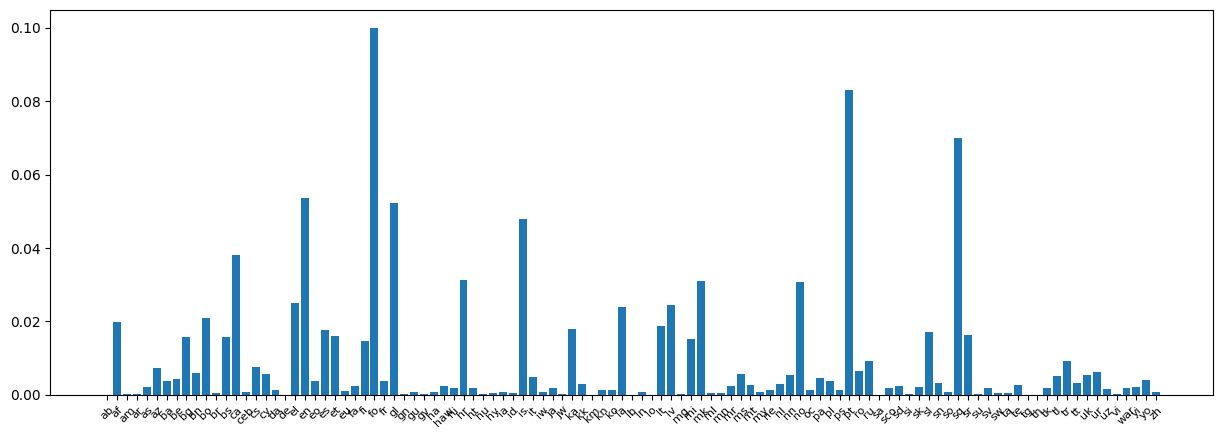

In [ ]:
# Plot the output distribution for a sample in a bar plot
import matplotlib.pyplot as plt
import numpy as np

def plot_distribution(dist):
    # x ticks are langs
    fig = plt.figure(figsize=(15, 5))
    langs = [idx2lang[i] for i in range(len(dist))]
    x = np.arange(len(langs))
    plt.bar(x, dist)
    plt.xticks(x, langs, rotation=45, size=8)
    plt.show()



# et_output_dists[0]

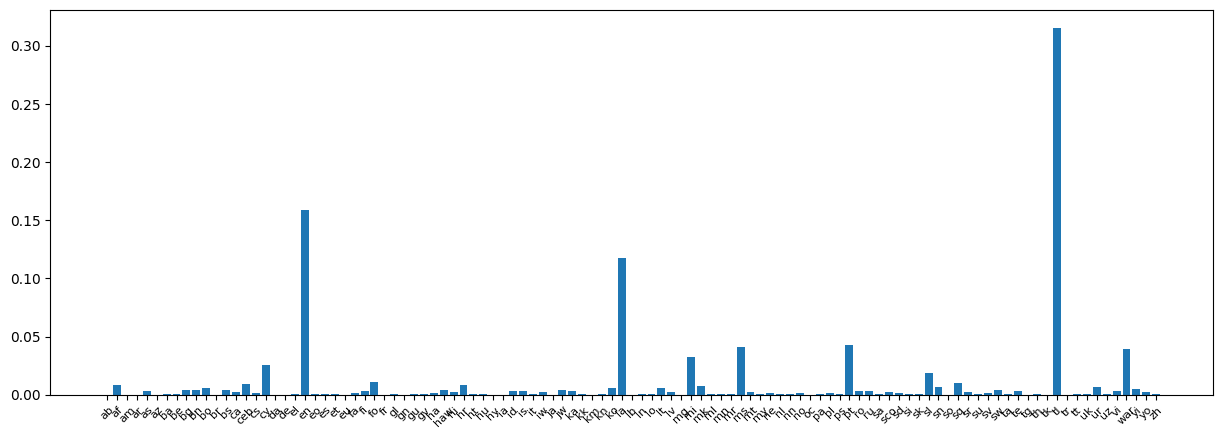

In [86]:
plot_distribution(phoneseq_output_dists[821])


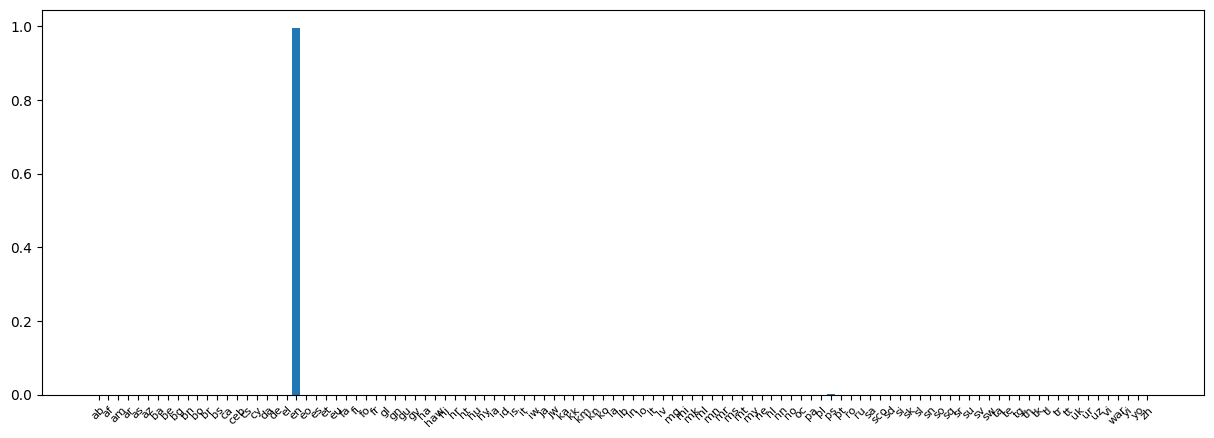

In [87]:
plot_distribution(et_output_dists[821])

In [82]:
all_accents[0]

'us'

In [90]:
##########
######### Getting eval numbers from phoneseq dataset



import torch
softmax = torch.nn.Softmax(dim=0)

dataset_dir = "vl107"

per_lang = 500
lang = "en"
batch_size = 1
only_eval = True
load_trained_from_dir = True
lid_model_type = "attentions-linear"
num_attention_layers = 8
num_epochs = 10
lr = 1e-3
evaluate_steps = 100
output_dir = "/exp/nbafna/projects/mitigating-accent-bias-in-lid/phoneseq_exps/vl107/wav2vec2-xlsr-53-espeak-cv-ft/attentions-linear-8/phoneseq_lid_model_outputs/"
eval_dataset_dir = "edacc"

lang2idx, idx2lang, langs = get_lang2idx_map(dataset_dir)  




def collate_fn_with_et_dists(batch):
    '''Pad the phoneme sequences to the maximum length'''
    model_max_len = 256
    padding_idx = 0
    sequences = [torch.tensor(item["sequence"]) for item in batch]
    truncated_sequences = [seq[:model_max_len] for seq in sequences]
    labels = [item["label"] for item in batch]
    accents = [item["accent"] for item in batch]
    et_output_distributions = [item["et_output_distributions"] for item in batch]

    # Pad the sequences with padding_idx=0, padded_sequences should be int tensor
    padded_sequences = torch.nn.utils.rnn.pad_sequence(truncated_sequences, batch_first=True, padding_value=padding_idx)
    padded_sequences = padded_sequences.type(torch.int64)
    labels = torch.tensor(labels)
    return {"input_values": padded_sequences, "labels": labels, "accents": accents, "et_output_distributions": et_output_distributions}



# Tokenize the phonetic sequences and labels
phoneme2idx_file = "/home/hltcoe/nbafna/projects/mitigating-accent-bias-in-lid/utils/wav2vec2phoneme_map/wav2vec2phoneme_map.json"
with open(phoneme2idx_file, "r") as f:
    phoneme2idx = json.load(f)
idx2phoneme = {idx: phoneme for phoneme, idx in phoneme2idx.items()}

if not only_eval:
    # Load dataset
    lid_dataset = load_phoneseq_dataset(dataset_dir, per_lang=per_lang)

    # Get the mapping from language to index
    
    lid_dataset = lid_dataset.map(map_tokenize_phoneme_labels, fn_kwargs={"phoneme2idx": phoneme2idx, "lang2idx": lang2idx}, \
        batched=True, \
        batch_size = 1000)
    
    # Split the dataset into training and validation
    train_dataset, dev_dataset, test_dataset = get_dataset_splits(lid_dataset, dev_size = 1000, test_size = 10000)


assert lid_model_type in ["attentions-linear"], "Invalid LID model type"
if only_eval:
    assert load_trained_from_dir, "If only evaluating, you must load the model from a directory"

# logger.info(f"Type of LID model: {lid_model_type}")

if lid_model_type == "attentions-linear":

    vocab_size = len(phoneme2idx)
    hidden_size = 256
    num_classes = len(idx2lang)
    # logger.info(f"Num classes: {num_classes}")
    lid_model = PhoneseqsLinearClassifiereonAttentionLayers(vocab_size=vocab_size, num_classes=num_classes, \
                            hidden_size=hidden_size, num_attention_layers=num_attention_layers, \
                                attention_dim=128, \
                                load_from_dir = load_trained_from_dir, output_dir = output_dir, \
                                batch_size = batch_size, lr = lr, num_epochs = num_epochs)



# Train the model
if not only_eval:
    logger.info(f"Training model...")
    lid_model.train(train_dataset, dev_dataset, evaluate_steps = evaluate_steps)
    lid_model.save()

    # Evaluate the model
    logger.info(f"Evaluating model on test split of train dataset...")
    preds, labels, accents, accuracy = lid_model.evaluate(test_dataset)
    logger.info(f"Accuracy: {accuracy}")

    # Save the predictions
    ## We'll save a list of audio files, their predicted labels, and their true labels
    # audio_files_test = [item["audio_file"] for item in test_dataset]
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    # accents = accents.cpu().numpy()
    preds = [idx2lang[pred] for pred in preds]
    labels = [idx2lang[label] for label in labels]

    with open(os.path.join(output_dir, "testset_predictions.pkl"), "wb") as f:
        # pkl.dump({"audio_files": audio_files_test, "preds": preds, "labels": labels}, f)
        pkl.dump({"preds": preds, "labels": labels, "accents": accents}, f)

    with open(os.path.join(output_dir, f"eval_accuracy.json"), "w") as f:
        json.dump({f"{dataset_dir}_test_accuracy": accuracy}, f)

# Evaluate the model on eval dataset if provided

if eval_dataset_dir:
    # logger.info(f"Evaluating model on eval dataset...")
    eval_dataset = load_phoneseq_dataset(eval_dataset_dir, lang=lang, target_code_type = dataset_dir)
    # eval_dataset = cv_dataset
    # eval_dataset = dataset
    # eval_dataset = dataset.filter(lambda x: len(x["phone_sequence"]) > 0)
    # audio_files = [item["audio_file"] for item in dataset]
    # eval_dataset = eval_dataset.filter(lambda x: x["audio_file"] in audio_files)
    print(f"Number of samples in eval dataset: {len(eval_dataset)}")

    eval_dataset = eval_dataset.map(map_tokenize_phoneme_labels, fn_kwargs={"phoneme2idx": phoneme2idx, "lang2idx": lang2idx}, \
        batched=True, \
        batch_size = 1000)

    # logger.info(f"Evaluating model on eval dataset...")
    # preds, labels, accents, accuracy = lid_model.evaluate(eval_dataset)
    # logger.info(f"Accuracy: {accuracy}")
    def predict_output_distribution(self, test_dataset, collate_fn):
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, collate_fn=collate_fn)
        self.model.eval()
        all_phoneseq_output_dists = []
        all_et_output_dists = []
        all_labels = []
        all_accents = []
        all_preds = []
        for batch in test_loader:
            if torch.cuda.is_available():
                input_values = batch["input_values"].cuda()
            else:
                input_values = batch["input_values"]
            with torch.no_grad():
                # print(input_values)
                outputs = lid_model.model(input_values)
                outputs = [softmax(output) for output in outputs]
                all_phoneseq_output_dists.extend(outputs)
                et_output_dists = torch.randn(batch_size, 107)
                all_et_output_dists.extend(et_output_dists)
                # preds = torch.argmax(outputs, dim=1)
                
                # all_preds.append(preds)
                all_labels.extend([label.item() for label in batch["labels"]])
                all_accents.extend(batch["accents"])
        return all_phoneseq_output_dists, all_et_output_dists, all_labels, all_accents
    
    phoneseq_output_dists, et_output_dists, all_labels, all_accents = predict_output_distribution(lid_model, eval_dataset, collate_fn)




    # Save the predictions
    ## We'll save a list of audio files, their predicted labels, and their true labels
    # audio_files_test = [item["audio_file"] for item in test_dataset]
    # preds = preds.cpu().numpy()
    # labels = labels.cpu().numpy()
    # accents = accents.cpu().numpy()
    # preds = [idx2lang[pred] for pred in preds]
    # labels = [idx2lang[label] for label in labels]

    # with open(os.path.join(output_dir, f"{eval_dataset_dir}_predictions.pkl"), "wb") as f:
    #     # pkl.dump({"audio_files": audio_files_test, "preds": preds, "labels": labels}, f)
    #     pkl.dump({"preds": preds, "labels": labels, "accents": accents}, f)
    
    # # Save accuracy to JSON file

    # if os.path.exists(os.path.join(output_dir, f"eval_accuracy.json")):
    #     results = json.load(open(os.path.join(output_dir, f"eval_accuracy.json")))
    # else:
    #     results = {}
    
    # results[f"{eval_dataset_dir}_accuracy"] = accuracy


/tmp/ipykernel_6641/1945168026.py:230: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(os.path.join(output_dir, f"phoneseqs_attentions-{num_attention_layers

Filtered out 8 samples with None phone sequences


Map:   0%|          | 0/13205 [00:00<?, ? examples/s]

Number of samples in eval dataset: 13205


Map:   0%|          | 0/13205 [00:00<?, ? examples/s]

forward pass
tensor([[ 4, 39,  9,  8, 55, 13, 37]])
forward pass
tensor([[12, 17,  5, 17, 21,  5, 44,  6, 46, 18, 30, 32,  9,  4,  5,  6, 41,  6,
         17, 42,  6, 29, 27, 30, 12, 22,  7, 18, 14,  5, 17, 60, 18,  8, 30, 21]])
forward pass
tensor([[11, 55,  8,  5,  6, 14,  8,  9, 41,  5, 11, 39, 43,  6, 29, 26, 27, 17,
         42, 22, 30, 21, 52, 17, 42, 21, 32, 17, 12, 22, 39, 43, 23, 27, 40, 13,
         22,  7,  5,  6, 40,  8,  5, 17]])
forward pass
tensor([[11,  5, 18, 46,  4, 33, 23, 27, 14, 38,  5,  4, 55, 18, 30,  5, 23, 37,
         25, 52, 17, 11,  5,  8, 36, 26, 21, 33, 25, 26,  8, 46, 66, 30, 21, 36,
          4, 12, 13, 44]])
forward pass
tensor([[26, 10, 20,  5,  4,  9, 11, 23, 55, 39, 43, 26, 27, 33, 22, 43, 26, 40,
         26, 32, 10, 40,  8,  5, 55,  4, 30, 12, 20,  5, 13, 40,  8, 18,  8,  9,
          5,  6, 17, 11,  5,  4, 44, 11, 36,  4, 12, 20]])
forward pass
tensor([[26, 17, 35,  6, 49, 23, 27, 40, 11, 23, 49, 12,  7, 11, 17, 12, 21, 38,
         30, 11, 36,  4